# Problem 
Kenneth has $4 and David has $3. They each bet $1 on a fair coin flip until one of them runs out of money. What is the relative probability of each one winning?

# Solution
We will model the system as an absorbing Markov chain. A Markov process is a random process that is blind to history; it's future state does not depend on its past. An absorvbing Markov chain is a Markov chain in which every state can reach an absorbing state, which is a state that cannot be left once entered. This notebook will be a walk through of how to set up the Markov chain model and how to calculate some useful quantities from it.

Much of the math used here was taken from:

https://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/Chapter11.pdf

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

%matplotlib inline

In [14]:
sns.set_context(context='poster')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['lines.markeredgewidth'] = 2

## Transition probability matrix

Model the system as an absorbing Markov chain with state space:

    states = {0, 1, 2, 3, 4, 5, 6, 7}

where each state corresponds to the amount of money currently held by one person. States 0 and 7 are the absorbing states, i.e., once the system enters those states they cannot transition to other states. States 1-5 are transition states.
    
Probability of transitioning from current state to -1 or +1 state is 0.5 and 0 for all other states

    P(i,i+1) = 0.5
    P(i+1,i) = 0.5

Once in the winning state, stay in the winning state

    P(7,7) = 1

Similarly, once in the losing state, stay in the losing state

    P(0,0) = 1

In [15]:
# Define the total amount of money in play and initialize the transition matrix
total_dollars = 7
P = np.zeros(shape=(total_dollars+1, total_dollars+1))

# Probabilty of transitioning to -1/+1 state = 0.5
for i in range(P.shape[0]-1):
    P[i,i+1] = .5
    P[i+1,i] = .5
    
# Once in the winning or losing state, i.e., all money or no money, stay there
P[0,:] = 0
P[0,0] = 1
P[total_dollars,:] = 0
P[total_dollars, total_dollars] = 1
    
# Check that all rows are normalized to 1
assert np.all(np.sum(P,axis=1)==1), 'Rows are not properly normalized'

## Canonical form
With the transition probability matrix in hand, we can re-write it in canonical form:

\begin{equation}
  C = \begin{bmatrix}
    Q & R \\
    0 & I 
  \end{bmatrix}
\end{equation}

where $Q$ describes the probabilities of transitioning among the transient states, $R$ describes the probabilities of transitioning from transient states to absorbing states, and I is the identity matrix.

The probability of transitining from state $i$ to state $j$ after n steps (or n flips in this case) is given by the $(i,j)$ entry in $Q^n$.

In [16]:
# Express the transition matrix in canonical form
# Move transition probabilities from/to absorbing states to the last rows/cols
C = deepcopy(P)
C = np.roll(C,-1,axis=0)
C = np.roll(C,-1, axis=1)

# Matrix indices now refer to following states:
state_order = [1,2,3,4,5,6,7,0]
#    e.g. C(0,7) == P(state 1 -> state 0) = 0.5 
#    e.g. C(6,6) == P(state 7 -> state 7) = 1

## Fundamental matrix

By summing $Q^k$ from $k=0$ to $k=\infty$, we get the expectation for the number of times the system is in state $j$ if it started in state $i$, which is the fundamental matrix, $N$. This the the sum of the probabilities for transitioning to/from each state over all possible states of the system (0 steps, or coin flips, to $\infty$ steps, or coin flips). It has been proven (certainly not by me) that:

\begin{equation}
N = \sum _ { k = 0 } ^ { \infty } Q ^ { k } = \left( I _ { t } - Q \right) ^ { - 1 }
\end{equation}

We can use the fundamental matrix with the components of the transition matrix in fundamental form to calculate lots of useful quantities!

For instance, since the matrix elements of N are the expected number of times the system visits each state $j$ given a starting state, $i$, we can sum along the final states, i.e. sum each row of N, to get the total number of transitions, or coin flips, before winning or losing.

In [27]:
# Fundamental matrix, N,  gives the expected number of times that the system will be
# in each transient state before absorbing given a particular starting state (row)
# Fundamental matrix N = (I-Q)^-1
Q = C[:6,:6]
I = np.identity(6)
N = np.linalg.inv(I-Q)

# Sum over rows to get the expected number of flips before winning/losing for each starting state
expected_flips = N.sum(axis=1)

# Print the expected_flips for each state, but remember that we have reordered the states when writing
# the transition probabilities in canonical form. We can index state_order to map back to the correct states.
print('Starting state : expected number of coin flips')
for i,nflips in enumerate(expected_flips):
    print(f'{state_order[i]} : {nflips:.0f}')

Starting state : expected number of coin flips
1 : 6
2 : 10
3 : 12
4 : 12
5 : 10
6 : 6


### Absorption probabilities
We are trying to calculate the relative probabilities of David or Kenneth winning the bet, i.e., the probabilities of ending up in either absorbing state given a particular starting state (in this case the starting state is 3 or 4, depending on whom we're modeling).

Since we know the probabilities for transitioning from transient states to absorbing states, $R$, and the expected number of times the system is in each state, $N$, we can calculate the absorbtion probabilities, B:

\begin{equation}
B = NR
\end{equation}

Each matrix element, ($i,j$), in B is the probability of starting in state $i$ and being absorbed into state $j$.

In [30]:
# R matrix of absorbtion probabilities 
R = C[:6,6:]

# Probability of each starting state ending in absorbing state
# B = NR
B = np.dot(N,R)

print(f'P(David wins) = {B[2,0]:.3f}')
print(f'P(Kenneth wins) = {B[3,0]:.3f}')

P(David wins) = 0.429
P(Kenneth wins) = 0.571


## Evolution of system after N flips
Just fo fun - we can see how the system evolves with coin flips. In order to get the probability distribution of the state space after n flips,$\mathbf{s}_n $, we just multiply the starting state vector, $\mathbf{s}_0$, by $P^n$:
  
\begin{equation}
\mathbf{s}_n = \mathbf{s}_0\mathbf{P}^n
\end{equation}

Let's see how the system evolves if we start with \$3:

\begin{equation}
\mathbf{s}_0 = [0, 0, 0, 1, 0, 0, 0, 0]
\end{equation}

In [37]:
# Get the transition matrix after n_flips
def flip(n_flips):
    return np.linalg.matrix_power(P,n_flips)

# Define initial state where David has $3
initial_state = np.zeros(total_dollars+1)
initial_state[3] = 1

In [84]:
# Set the number of flips and create an array to store the state of the system after each flip
n_flips = 50
states = np.ndarray(shape=(n_flips, initial_state.shape[0]))

# Flip, flip, flip!
for n in range(n_flips):
    states[n] = np.dot(initial_state, flip(n))

## Visualize evolution of the system
Since we saved the distribution of states after each coin flip, we can visualize how the system changed with each flip. Let's plot the probability of being in each state over the course of 30 flips.

Note that the probabilities of entering state 0 or 7 converge towards the losing and winning probabilities we found earlier, while the probabilities for being in any of the other states tend towards 0.

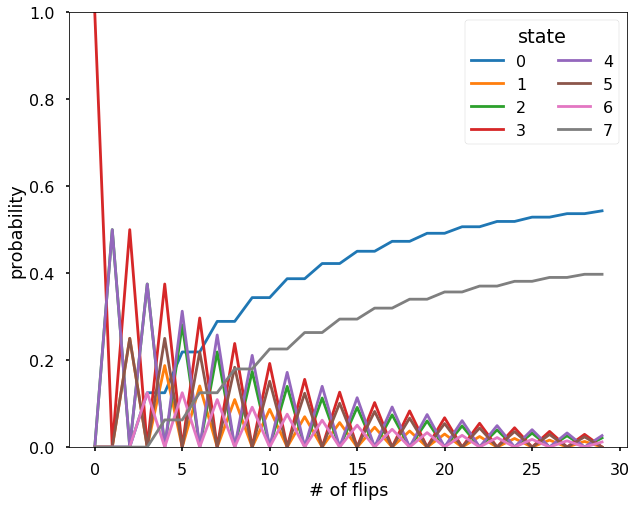

In [85]:
# Plot probability of being in each state vs. the number of flips
fig, ax = plt.subplots()
flips = np.arange(n_flips)

for i, color in zip(range(states.shape[1]), colors):
    ax.plot(flips[:30], states[:30,i], label=i)

ax.set_ylim([0,1])
ax.set_xlabel('# of flips')
ax.set_ylabel('probability')
ax.legend(title='state', ncol=2)

Probablity that David wins after 50 flips   = 0.4247
Probablity that Kenneth wins after 50 flips = 0.5679


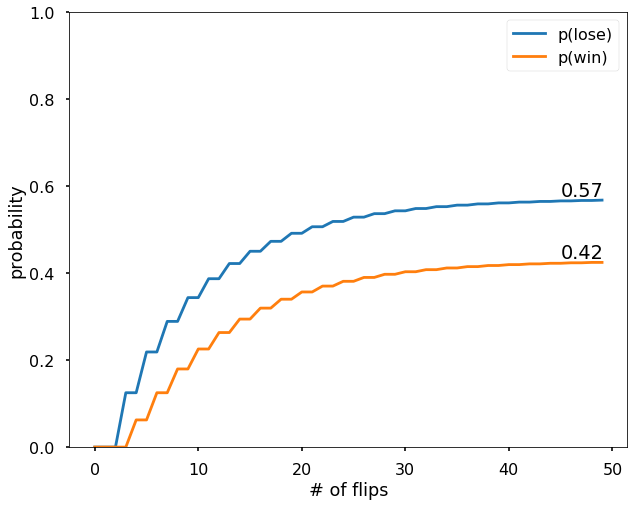

In [86]:
# Here's another plot of probability vs. # of flips but only looking at the winning and losing states
fig, ax = plt.subplots()
s = np.arange(n_flips)
ax.plot(s, states[:,0], label='p(lose)')
ax.plot(s, states[:,total_dollars], label='p(win)')
ax.set_ylim([0,1])
ax.set_xlabel('# of flips')
ax.set_ylabel('probability')
ax.legend()

p_win = states[-1,total_dollars]
p_lose = states[-1,0]
ax.annotate(f'{p_win:.2f}', xy=(n_flips-5, p_win+.01), textcoords='data')
ax.annotate(f'{p_lose:.2f}', xy=(n_flips-5, p_lose+.01), textcoords='data')


# What's the probability of each person winning after 50 flips?
# Although note that we only expect 12 flips before winning or losing, so we've most likely reached
# one of the absorbing states much earlier!
print(f'Probablity that David wins after {n_flips} flips   = {states[n_flips-1, -1]:.4f}')
print(f'Probablity that Kenneth wins after {n_flips} flips = {states[n_flips-1, 0]:.4f}')

Text(0, 0.5, 'state')

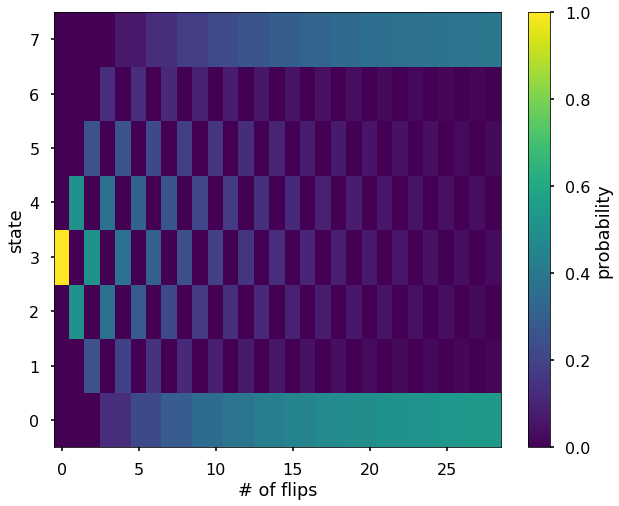

In [87]:
# Plot colormap of the probability of being in each state after n flips
# Shift the x and y values by 0.5 so that the the flips and states boxes are centered
# Add 1 to length of state space in order to center state 7 at 7.5
fig, ax = plt.subplots()
im = ax.pcolormesh(flips[:30] - .5, np.arange(states.shape[1]+1)-.5, states[:30,:].T, cmap='viridis')
plt.colorbar(im, label='probability')

ax.set_xlabel('# of flips')
ax.set_ylabel('state')